In [1]:
import os
import wget
import gzip
import math
import matplotlib.pyplot as plt
import numpy as np
import random
import sklearn
import string
from collections import defaultdict
from gensim.models import Word2Vec
from nltk.stem.porter import *
from sklearn import linear_model
from sklearn.manifold import TSNE

Data is available at http://cseweb.ucsd.edu/~jmcauley/pml/data/. 
- Download and save to your own directory.
- Or, run following script to save it into `Chapter_8/data` folder automatically.

In [2]:
filenames = [
    'beer_50000.json',
    'goodreads_reviews_fantasy_paranormal.json.gz',
]

dataDir = './data'
url = 'http://jmcauley.ucsd.edu/pml_data'

if not os.path.exists(dataDir):
    os.makedirs(dataDir)
for filename in filenames:
    wget.download(os.path.join(url, filename), out=dataDir)

print("Done!")

Done!


# Bag-of-words models

In [3]:
def parseData(fname):
    for l in open(fname):
        yield eval(l)

In [4]:
data = list(parseData(os.path.join(dataDir, "beer_50000.json")))[:5000]

How many unique words are there?

In [5]:
wordCount = defaultdict(int)
for d in data:
    for w in d['review/text'].split():
        wordCount[w] += 1

len(wordCount)

36225

Ignore capitalization and remove punctuation

In [6]:
wordCount = defaultdict(int)
punctuation = set(string.punctuation)
for d in data:
    r = ''.join([c for c in d['review/text'].lower() if not c in punctuation])
    for w in r.split():
        wordCount[w] += 1

len(wordCount)

19426

With stemming

In [7]:
wordCount = defaultdict(int)
punctuation = set(string.punctuation)
stemmer = PorterStemmer()
for d in data:
  r = ''.join([c for c in d['review/text'].lower() if not c in punctuation])
  for w in r.split():
    w = stemmer.stem(w)
    wordCount[w] += 1
    
len(wordCount)

14847

Just build our feature vector by taking the most popular words (lowercase, punctuation removed, but no stemming)

In [8]:
wordCount = defaultdict(int)
punctuation = set(string.punctuation)
for d in data:
  r = ''.join([c for c in d['review/text'].lower() if not c in punctuation])
  for w in r.split():
    wordCount[w] += 1

counts = [(wordCount[w], w) for w in wordCount]
counts.sort()
counts.reverse()

In [9]:
words = [x[1] for x in counts[:1000]]

# Sentiment analysis

In [10]:
wordId = dict(zip(words, range(len(words))))
wordSet = set(words)

In [11]:
def feature(datum):
    feat = [0]*len(words)
    r = ''.join([c for c in datum['review/text'].lower() if not c in punctuation])
    for w in r.split():
        if w in words:
            feat[wordId[w]] += 1
    feat.append(1) # offset
    return feat

Extract bag-of-word features. For a bigger dataset, replace this with a sparse matrix to save memory (see examples in Chapter 6)

In [12]:
X = [feature(d) for d in data]
y = [d['review/overall'] for d in data]

In [13]:
# Regularized regression
clf = linear_model.Ridge(1.0, fit_intercept=False) # MSE + 1.0 l2
clf.fit(X, y)
theta = clf.coef_
predictions = clf.predict(X)

# N-grams

Simple example...

In [14]:
sentence = "Dark red color, light beige foam"
unigrams = sentence.split()
bigrams = list(zip(unigrams[:-1], unigrams[1:]))
trigrams = list(zip(unigrams[:-2], unigrams[1:-1], unigrams[2:]))

In [15]:
trigrams

[('Dark', 'red', 'color,'),
 ('red', 'color,', 'light'),
 ('color,', 'light', 'beige'),
 ('light', 'beige', 'foam')]

Extract n-grams up to length 5 (same dataset as example above)

In [16]:
wordCount = defaultdict(int)
punctuation = set(string.punctuation)
for d in data:
    r = ''.join([c for c in d['review/text'].lower() if not c in punctuation])
    ws = r.split()
    ws2 = [' '.join(x) for x in list(zip(ws[:-1],ws[1:]))]
    ws3 = [' '.join(x) for x in list(zip(ws[:-2],ws[1:-1],ws[2:]))]
    ws4 = [' '.join(x) for x in list(zip(ws[:-3],ws[1:-2],ws[2:-1],ws[3:]))]
    ws5 = [' '.join(x) for x in list(zip(ws[:-4],ws[1:-3],ws[2:-2],ws[3:-1],ws[4:]))]
    for w in ws + ws2 + ws3 + ws4 + ws5:
        wordCount[w] += 1

counts = [(wordCount[w], w) for w in wordCount]
counts.sort()
counts.reverse()

In [17]:
words = [x[1] for x in counts[:1000]]

A few of our 1000 most popular n-grams. Note the combination of n-grams of different lengths

In [18]:
words[200:210]

['pint',
 'hoppy',
 'stout',
 'though',
 'lots',
 'and the',
 'malty',
 'mouthfeel is',
 'even',
 'quickly']

In [19]:
wordId = dict(zip(words, range(len(words))))
wordSet = set(words)

In [20]:
def feature(datum):
    feat = [0]*len(words)
    r = ''.join([c for c in datum['review/text'].lower() if not c in punctuation])
    ws = r.split()
    ws2 = [' '.join(x) for x in list(zip(ws[:-1],ws[1:]))]
    ws3 = [' '.join(x) for x in list(zip(ws[:-2],ws[1:-1],ws[2:]))]
    ws4 = [' '.join(x) for x in list(zip(ws[:-3],ws[1:-2],ws[2:-1],ws[3:]))]
    ws5 = [' '.join(x) for x in list(zip(ws[:-4],ws[1:-3],ws[2:-2],ws[3:-1],ws[4:]))]
    for w in ws + ws2 + ws3 + ws4 + ws5:
        if w in words:
            feat[wordId[w]] += 1
    feat.append(1) #offset
    return feat

Same as the model in the previous example above, except using n-grams rather than just unigrams

In [21]:
X = [feature(d) for d in data]
y = [d['review/overall'] for d in data]

In [22]:
clf = linear_model.Ridge(1.0, fit_intercept=False) # MSE + 1.0 l2
clf.fit(X, y)
theta = clf.coef_
predictions = clf.predict(X)

In [23]:
wordSort = list(zip(theta[:-1], words))
wordSort.sort()

Some of the most negative and positive n-grams...

In [24]:
wordSort[:20]

[(-0.39143632655626803, 'a lot of'),
 (-0.2821229351696297, 'a bit more'),
 (-0.266114117041166, 'water'),
 (-0.25302293141511417, 'the background'),
 (-0.24105277280699952, 'corn'),
 (-0.21580888155065722, 'as it warms'),
 (-0.2047088897727647, 'hint of'),
 (-0.20324036428959297, 'yellow'),
 (-0.19776086681430885, 'little more'),
 (-0.19515009289477386, 'watery'),
 (-0.1833549486926249, 'straw'),
 (-0.17846828826478417, 'a hint'),
 (-0.1749628781772613, 'around the'),
 (-0.17387445409086638, 'kind'),
 (-0.17381459136980515, 'down the'),
 (-0.17231514207705736, 'lot'),
 (-0.16887649424485857, 'weak'),
 (-0.16647751584897513, 'bad'),
 (-0.16513650187977286, 'old'),
 (-0.15815384283001288, 'up to')]

In [25]:
wordSort[-20:]

[(0.15966172741192136, 'wonderful'),
 (0.16316670449503673, 'off white head'),
 (0.17379190414349227, 'a little more'),
 (0.17560247184995745, 'favorite'),
 (0.17674628573616227, 'not too'),
 (0.17724972085645027, 'i really'),
 (0.179194864201328, 'easy to'),
 (0.18200914314267735, 'i am'),
 (0.18394566780122154, 'background'),
 (0.18752400440819525, 'touch of'),
 (0.19751810949895576, 'the best'),
 (0.1993381723047037, 'hint'),
 (0.21249123771081643, 'this one is'),
 (0.21410451475904752, 'a hint of'),
 (0.2204377788013403, 'not bad'),
 (0.23768919746952694, 'of these'),
 (0.23871898220030408, 'a bad'),
 (0.24874277211061382, 'lot of'),
 (0.27486534793242434, 'a lot'),
 (0.31217415648841607, 'bit more')]

# TF-IDF

In [26]:
dataset = []

Small set of Goodreads fantasy reviews

In [27]:
z = gzip.open(os.path.join(dataDir, "goodreads_reviews_fantasy_paranormal.json.gz"))
for l in z.readlines():
    dataset.append(eval(l))
    if len(dataset) == 50000:
        break

For example...

In [28]:
dataset[0]

{'user_id': '8842281e1d1347389f2ab93d60773d4d',
 'book_id': '18245960',
 'review_id': 'dfdbb7b0eb5a7e4c26d59a937e2e5feb',
 'rating': 5,
 'review_text': 'This is a special book. It started slow for about the first third, then in the middle third it started to get interesting, then the last third blew my mind. This is what I love about good science fiction - it pushes your thinking about where things can go. \n It is a 2015 Hugo winner, and translated from its original Chinese, which made it interesting in just a different way from most things I\'ve read. For instance the intermixing of Chinese revolutionary history - how they kept accusing people of being "reactionaries", etc. \n It is a book about science, and aliens. The science described in the book is impressive - its a book grounded in physics and pretty accurate as far as I could tell. Though when it got to folding protons into 8 dimensions I think he was just making stuff up - interesting to think about though. \n But what would 

Similar process to extract bag-of-words representations as in previous examples

In [29]:
wordCount = defaultdict(int)
punctuation = set(string.punctuation)
for d in dataset:
    r = ''.join([c for c in d['review_text'].lower() if not c in punctuation])
    for w in r.split():
        wordCount[w] += 1

In [30]:
counts = [(wordCount[w], w) for w in wordCount]
counts.sort()
counts.reverse()

In [31]:
words = [x[1] for x in counts[:1000]]

### Document frequency (df)

In [32]:
df = defaultdict(int)
for d in dataset:
    r = ''.join([c for c in d['review_text'].lower() if not c in punctuation])
    for w in set(r.split()):
        df[w] += 1

### Term frequency (tf)

Here we extract frequencies for terms in a single specific review

In [33]:
rev = dataset[9] # Query review
rev

{'user_id': '8842281e1d1347389f2ab93d60773d4d',
 'book_id': '76620',
 'review_id': '9206654986a733bd753753aa0c882813',
 'rating': 5,
 'review_text': "I read this after hearing from a few people that it was among their all-time favorites. I was almost put off when I saw it was a story about rabbits, originally written as a tale by a father to his children - but I'm glad I wasn't. \n I found the folk tales about El-ahrairah to be very impressive. The author clearly had a vivid imagination to create so much of the rabbits culture and history. But I think this book was worth reading as it's really a story about survival, leadership, and human nature. \n Oh and Fiver rocks. And BigWig is the man.",
 'date_added': 'Tue Sep 02 17:03:40 -0700 2008',
 'date_updated': 'Wed Dec 14 12:30:43 -0800 2016',
 'read_at': 'Tue May 05 00:00:00 -0700 2015',
 'started_at': 'Sun Apr 19 00:00:00 -0700 2015',
 'n_votes': 30,
 'n_comments': 2}

In [34]:
tf = defaultdict(int)
r = ''.join([c for c in rev['review_text'].lower() if not c in punctuation])
for w in r.split():
    # Note = rather than +=, different versions of tf could be used instead
    tf[w] = 1
    
tfidf = dict(zip(words,[tf[w] * math.log2(len(dataset) / df[w]) for w in words]))
tfidfQuery = [tf[w] * math.log2(len(dataset) / df[w]) for w in words]

Find the highest tf-idf words in our example review

In [35]:
maxTf = [(tf[w],w) for w in words]
maxTf.sort(reverse=True)
maxTfIdf = [(tfidf[w],w) for w in words]
maxTfIdf.sort(reverse=True)

In [36]:
maxTfIdf[:10]

[(6.475214154215886, 'nature'),
 (6.1604918290613755, 'tales'),
 (5.77675046027207, 'children'),
 (5.7117950184313, 'saw'),
 (5.316168825598678, 'history'),
 (5.286585714095165, 'father'),
 (4.98210658996402, 'worth'),
 (4.910068021149542, 'glad'),
 (4.881720019873613, 'human'),
 (4.731589561708275, 'tale')]

Cosine similarity

In [37]:
def Cosine(x1,x2):
    numer = 0
    norm1 = 0
    norm2 = 0
    for a1,a2 in zip(x1,x2):
        numer += a1*a2
        norm1 += a1**2
        norm2 += a2**2
    if norm1*norm2:
        return numer / math.sqrt(norm1*norm2)
    return 0

Find the other reviews in the corpus with the highest cosine similarity between tf-idf vectors

In [38]:
similarities = []
for rev2 in dataset:
    tf = defaultdict(int)
    r = ''.join([c for c in rev2['review_text'].lower() if not c in punctuation])
    for w in r.split():
        # Note = rather than +=
        tf[w] = 1
    tfidf2 = [tf[w] * math.log2(len(dataset) / df[w]) for w in words]
    similarities.append((Cosine(tfidfQuery, tfidf2), rev2['review_text']))

In [39]:
similarities.sort(reverse=True)

In [40]:
similarities[:10]

[(1.0,
  "I read this after hearing from a few people that it was among their all-time favorites. I was almost put off when I saw it was a story about rabbits, originally written as a tale by a father to his children - but I'm glad I wasn't. \n I found the folk tales about El-ahrairah to be very impressive. The author clearly had a vivid imagination to create so much of the rabbits culture and history. But I think this book was worth reading as it's really a story about survival, leadership, and human nature. \n Oh and Fiver rocks. And BigWig is the man."),
 (0.33623828530476574,
  'Need a review \n For a full explanation of the provenance and history of Arabian Nights, as well as an alternative translation, see \n https://www.theatlantic.com/entertain... \n For children, see \n Aladdin and Other Tales from the Arabian Nights, Dawood, 1960 \n https://www.goodreads.com/review/show...'),
 (0.2944751254505903,
  'Awesome! Love this author and his story world. Found quite a few errors/typo

# word2vec (gensim)

A few utility data structures (used later)

In [41]:
beerStyles = {} # Style of each item
categories = set() # Set of item categories
reviewsPerUser = defaultdict(list)
beerIdToName = {} # Map an ID to the name of the product

In [42]:
z = open(os.path.join(dataDir, "beer_50000.json"))

reviews = []
reviewDicts = []

for l in z:
    d = eval(l)
    reviews.append(d['review/text'])
    beerStyles[d['beer/beerId']] = d['beer/style']
    categories.add(d['beer/style'])
    beerIdToName[d['beer/beerId']] = d['beer/name']
    reviewsPerUser[d['user/profileName']].append((d['review/timeUnix'], d['beer/beerId']))
    reviewDicts.append(d)
    if len(reviews) == 50000:
        break

Tokenize the reviews, so that each review becomes a list of words

In [43]:
reviewTokens = []

In [44]:
punctuation = set(string.punctuation)
for r in reviews:
    r = ''.join([c for c in r.lower() if not c in punctuation])
    tokens = []
    for w in r.split():
        tokens.append(w)
    reviewTokens.append(tokens)

Example of a tokenized review

In [45]:
reviewTokens[0]

['a',
 'lot',
 'of',
 'foam',
 'but',
 'a',
 'lot',
 'in',
 'the',
 'smell',
 'some',
 'banana',
 'and',
 'then',
 'lactic',
 'and',
 'tart',
 'not',
 'a',
 'good',
 'start',
 'quite',
 'dark',
 'orange',
 'in',
 'color',
 'with',
 'a',
 'lively',
 'carbonation',
 'now',
 'visible',
 'under',
 'the',
 'foam',
 'again',
 'tending',
 'to',
 'lactic',
 'sourness',
 'same',
 'for',
 'the',
 'taste',
 'with',
 'some',
 'yeast',
 'and',
 'banana']

Fit the word2vec model

In [46]:
model = Word2Vec(reviewTokens,
                 min_count=5, # Words/items with fewer instances are discarded
                 vector_size=10, # Model dimensionality
                 window=3, # Window size
                 sg=1) # Skip-gram model

Extract word representation for a particular word

In [47]:
model.wv['yeast']

array([-0.15706667,  0.12135503, -0.03660804,  0.8428384 ,  0.9300465 ,
        0.44028518,  0.42346454,  0.3768172 , -1.3731192 , -0.3212263 ],
      dtype=float32)

Find similar words to a given query

In [48]:
model.wv.similar_by_word("grassy")

[('floral', 0.9921375513076782),
 ('citrus', 0.9904512763023376),
 ('citric', 0.9889377355575562),
 ('spicy', 0.984530508518219),
 ('flowery', 0.984245240688324),
 ('grapefruity', 0.9804825186729431),
 ('piney', 0.9802461862564087),
 ('piny', 0.9785940051078796),
 ('pine', 0.9781995415687561),
 ('earthy', 0.9767197966575623)]

# item2vec

Almost the same as word2vec, but "documents" are made up of sequences of item IDs rather than words

In [49]:
reviewLists = []
for u in reviewsPerUser:
    rl = list(reviewsPerUser[u])
    rl.sort()
    reviewLists.append([x[1] for x in rl])

In [50]:
model10 = Word2Vec(reviewLists,
                 min_count=5, # Words/items with fewer instances are discarded
                 vector_size=10, # Model dimensionality
                 window=3, # Window size
                 sg=1) # Skip-gram model

In [51]:
beerIdToName['7360']

'Crystal Bitter Ale'

In [52]:
model10.wv.similar_by_word('7360')

[('48301', 0.9902342557907104),
 ('6029', 0.9889376759529114),
 ('4371', 0.9888631701469421),
 ('13112', 0.9875540137290955),
 ('49360', 0.9865210056304932),
 ('5360', 0.9858759641647339),
 ('4374', 0.9854435324668884),
 ('57959', 0.9852198958396912),
 ('67507', 0.9848983883857727),
 ('59315', 0.9837827086448669)]

In [53]:
for b in model10.wv.similar_by_word('7360'):
    print(beerIdToName[b[0]])

Oatmeal Ellie
Cascade Amber
Brown's Point ESB
IPA
Reckoning
IPA
Rajah's Royal IPA
Bad Knees Barrel Aged Old Ale
Mornington Peninsula Brown Ale
Master ZlatÃ½ 15Â°


# t-SNE embedding

Visualize the embeddings from the model above using t-SNE

In [54]:
X = []
beers = []
for b in beerIdToName:
    try:
        X.append(list(model10.wv[b]))
        beers.append(b)
    except Exception as e:
        pass

Fit a model with just two components for the sake of visualization

In [55]:
X_embedded = TSNE(n_components=2).fit_transform(X)

/home/zhankui/anaconda3/envs/pml/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/zhankui/anaconda3/envs/pml/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


Generate scatterplots using the embedded points (one scatter plot per category)

In [56]:
scatterPlotsX = defaultdict(list)
scatterPlotsY = defaultdict(list)
for xy, b in zip(X, beers):
    cat = beerStyles[b]
    try:
        scatterPlotsX[cat].append(xy[0])
        scatterPlotsY[cat].append(xy[1])
    except Exception as e:
        pass

Plot data from a few categories (more interesting with a larger dataset)

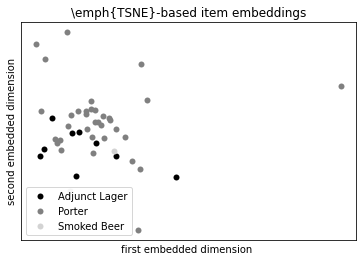

In [57]:
plt.scatter(scatterPlotsX['American Adjunct Lager'],
            scatterPlotsY['American Adjunct Lager'], color='k', lw=0, label="Adjunct Lager")
plt.scatter(scatterPlotsX['American Porter'],
            scatterPlotsY['American Porter'], color='grey', lw=0, label = "Porter")
plt.scatter(scatterPlotsX['Smoked Beer'],
            scatterPlotsY['Smoked Beer'], color='lightgrey', lw = 0, label = "Smoked Beer")
plt.legend(loc='lower left')
plt.xticks([])
plt.yticks([])
plt.xlabel("first embedded dimension ")
plt.ylabel("second embedded dimension")
plt.title("\emph{TSNE}-based item embeddings")
plt.show()

# Exercises

### 8.1 / 8.2

Simple sentiment analysis pipeline

In [58]:
def parseData(fname):
    for l in open(fname):
        yield eval(l)

In [59]:
data = list(parseData(os.path.join(dataDir, "beer_50000.json")))[:5000]

In [60]:
random.shuffle(data)

Add a couple of "options" for the representation (in this case whether we should convert to lower case, remove puncuation). More could be added.

In [61]:
def feature(datum, words, wordId, tolower=True, removePunct=True):
    feat = [0]*len(words)
    r = datum['review/text']
    if tolower:
        r = r.lower()
    if removePunct:
        r = ''.join([c for c in r if not c in punctuation])
    for w in r.split():
        if w in words:
            feat[wordId[w]] += 1
    feat.append(1) # offset
    return feat

Condense the pipeline code (see Chapter 3) into a single function

In [62]:
def pipeline(dSize = 1000, tolower=True, removePunct=True):
    wordCount = defaultdict(int)
    punctuation = set(string.punctuation)
    for d in data: # Strictly, should just use the *training* data to extract word counts
        r = d['review/text']
        if tolower:
            r = r.lower()
        if removePunct:
            r = ''.join([c for c in r if not c in punctuation])
        for w in r.split():
            wordCount[w] += 1

    counts = [(wordCount[w], w) for w in wordCount]
    counts.sort()
    counts.reverse()
    
    words = [x[1] for x in counts[:dSize]]
    
    wordId = dict(zip(words, range(len(words))))
    wordSet = set(words)
    
    X = [feature(d, words, wordId, tolower, removePunct) for d in data]
    y = [d['review/overall'] for d in data]
    
    Ntrain,Nvalid,Ntest = 4000,500,500
    Xtrain,Xvalid,Xtest = X[:Ntrain],X[Ntrain:Ntrain+Nvalid],X[Ntrain+Nvalid:]
    ytrain,yvalid,ytest = y[:Ntrain],y[Ntrain:Ntrain+Nvalid],y[Ntrain+Nvalid:]
    
    bestModel = None
    bestVal = None
    bestLamb = None
    
    ls = [0.01, 0.1, 1, 10, 100, 1000, 10000]
    errorTrain = []
    errorValid = []

    for l in ls:
        model = sklearn.linear_model.Ridge(l)
        model.fit(Xtrain, ytrain)
        predictTrain = model.predict(Xtrain)
        MSEtrain = sum((ytrain - predictTrain)**2)/len(ytrain)
        errorTrain.append(MSEtrain)
        predictValid = model.predict(Xvalid)
        MSEvalid = sum((yvalid - predictValid)**2)/len(yvalid)
        errorValid.append(MSEvalid)
        print("l = " + str(l) + ", validation MSE = " + str(MSEvalid))
        if bestVal == None or MSEvalid < bestVal:
            bestVal = MSEvalid
            bestModel = model
            bestLamb = l
            
    predictTest = bestModel.predict(Xtest)
    MSEtest = sum((ytest - predictTest)**2)/len(ytest)
    MSEtest
    
    plt.xticks([])
    plt.xlabel(r"$\lambda$")
    plt.ylabel(r"error (MSE)")
    plt.title(r"Validation Pipeline")
    plt.xscale('log')
    plt.plot(ls, errorTrain, color='k', linestyle='--', label='training error')
    plt.plot(ls, errorValid, color='grey',zorder=4,label="validation error")
    plt.plot([bestLamb], [MSEtest], linestyle='', marker='x', color='k', label="test error")
    plt.legend(loc='best')
    plt.show()

Run models with different feature representation options and dictionary sizes

l = 0.01, validation MSE = 0.9307009934191642
l = 0.1, validation MSE = 0.9217558581288334
l = 1, validation MSE = 0.8508519384871486
l = 10, validation MSE = 0.6229448597385991
l = 100, validation MSE = 0.4657128930525531
l = 1000, validation MSE = 0.47911707939523773
l = 10000, validation MSE = 0.5635510877872827


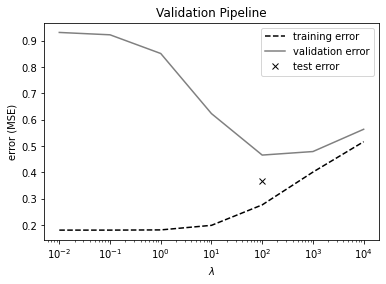

In [63]:
pipeline(2000, False, False)

l = 0.01, validation MSE = 0.5210260411676192
l = 0.1, validation MSE = 0.520525070790201
l = 1, validation MSE = 0.515773549466803
l = 10, validation MSE = 0.4845338070551939
l = 100, validation MSE = 0.43405459058445606
l = 1000, validation MSE = 0.456502418222912
l = 10000, validation MSE = 0.537922528208773


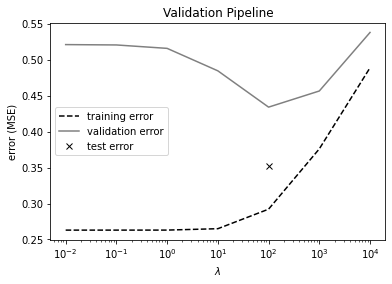

In [64]:
pipeline(1000, True, True)

### 8.3

Use item2vec to make recommendations (following code from exercises in Chapter 4)

In [65]:
def recScore(i, userHistory):
    historyInVocab = [w for w in userHistory if w in model10.wv]
    if len(historyInVocab) == 0:
        return 0
    sc = model10.wv.distance(str(i), historyInVocab[-1])
    return sc

def rec(userHistory):
    historyInVocab = [w for w in userHistory if w in model10.wv]
    if len(historyInVocab) == 0:
        return 0
    return model10.wv.most_similar(positive = historyInVocab, topn=10)

In [66]:
recScore(20539, reviewLists[0])

0.22419297695159912

In [67]:
rec(reviewLists[0])

[('4872', 0.9914255142211914),
 ('31063', 0.9814524054527283),
 ('30034', 0.9814499020576477),
 ('12073', 0.9812331795692444),
 ('1418', 0.9807156920433044),
 ('36367', 0.9803662300109863),
 ('14014', 0.9797950983047485),
 ('12734', 0.9787745475769043),
 ('17160', 0.9782428741455078),
 ('19309', 0.9782235622406006)]

### 8.4

(see tf-idf retrieval examples above)

### 8.5

Predict the rating using item2vec item similarity scores. Adapts models from Chapter 4.

In [68]:
ratingMean = sum([d['review/overall'] for d in reviewDicts]) / len(reviewDicts)

In [69]:
itemAverages = defaultdict(list)
reviewsPerUser = defaultdict(list)
    
for d in reviewDicts:
    i = d['beer/beerId']
    u = d['user/profileName']
    itemAverages[i].append(d['review/overall'])
    reviewsPerUser[u].append(d)
    
for i in itemAverages:
    itemAverages[i] = sum(itemAverages[i]) / len(itemAverages[i])

In [70]:
def predictRating(user,item):
    ratings = []
    similarities = []
    if not str(item) in model10.wv:
        return ratingMean
    for d in reviewsPerUser[user]:
        i2 = d['beer/beerId']
        if i2 == item: continue
        ratings.append(d['review/overall'] - itemAverages[i2])
        if str(i2) in model10.wv:
            similarities.append(model10.wv.distance(str(item), str(i2)))
    if (sum(similarities) > 0):
        weightedRatings = [(x*y) for x,y in zip(ratings,similarities)]
        return itemAverages[item] + sum(weightedRatings) / sum(similarities)
    else:
        return ratingMean

In [71]:
u,i = reviewDicts[0]['user/profileName'],reviewDicts[0]['beer/beerId']

In [72]:
predictRating(u,i)

3.88871

In [73]:
ratingMean

3.88871

In [74]:
alwaysPredictMean = [ratingMean for _ in reviewDicts]

In [75]:
labels = [d['review/overall'] for d in reviewDicts]

In [76]:
predictions = [predictRating(d['user/profileName'],d['beer/beerId']) for d in reviewDicts]

In [77]:
def MSE(predictions, labels):
    differences = [(x-y)**2 for x,y in zip(predictions,labels)]
    return sum(differences) / len(differences)

In [78]:
MSE(alwaysPredictMean, labels)

0.4924295358999677

In [79]:
MSE(predictions, labels)

0.41646764685709614